In [2]:
import dotenv
import os
import re
import os
import glob
import pandas as pd
import numpy as np
import openai
import json

dotenv.load_dotenv()

OPENAI_KEY = os.environ.get("OPENAI_API_KEY")

q_and_a_behavior_df = pd.read_csv('behavior_level.csv')
q_and_a_experiment_df = pd.read_csv('experimental_level.csv')

master_db_df = pd.read_csv('MasterDB_Full.csv')
master_db_df['Paper_Exp_ID_better'] = master_db_df.Paper_Exp_ID.str.extract(r'([A-Z]\_\d+)')

In [11]:
article_ids_list = [
    "A_114",
    "A_116",
    "A_137",
    "A_152",
    "A_168",
    "A_168",
    "A_168",
    "A_181",
    "A_197",
    "A_19",
    "A_228",
    "A_30",
    "A_31",
    "A_39",
    "A_39",
    "A_55",
    "A_62",
    "A_76",
    "A_87",
]

file_dict = {}

folder_path = "sample_paper"
markdown_pattern = "*.mmd"
markdown_files = glob.glob(os.path.join(folder_path, markdown_pattern))

pattern_id = r'([A-Z]\_\d+)'

for markdown_file in markdown_files:
    match = re.search(pattern_id, markdown_file)
    if match:
        code = match.group(1)
        if code in file_dict:
            file_dict[code].append(markdown_file)
        else:
            file_dict[code] = [markdown_file]
    else:
        print("No match found.")


In [12]:
file_dict['A_19']

['sample_paper/A_19_2022_DoHonestyNudges.mmd']

### Creates a vector database from the files for the given article id

In [3]:
from langchain.document_loaders import TextLoader
from langchain.text_splitter import MarkdownHeaderTextSplitter
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings
from pathlib import Path


def read_files_to_vector(docs: list):
    text = ""
    for d in docs:
        text += Path(d).read_text()

    headers_to_split_on = [
        ("#", "Header 1"),
        ("##", "Header 2"),
        ("###", "Header 3"),
        ("####", "Header 4"),
    ]

    markdown_splitter = MarkdownHeaderTextSplitter(
        headers_to_split_on=headers_to_split_on
    )
    md_header_splits = markdown_splitter.split_text(text)

    text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=200)
    splits = text_splitter.split_documents(md_header_splits)

    embedding = OpenAIEmbeddings(openai_api_key=OPENAI_KEY)

    vectordb = Chroma.from_documents(documents=splits, embedding=embedding)

    return vectordb

### Article class where the vectordb is saved and you can query the database

In [4]:
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.callbacks import get_openai_callback


class ArticleQA:
    def __init__(self, vector_db, model="gpt-4"):
        self.model = model
        self.vector_db = vector_db

    def query_context(self, question, answer_format):
        # Build prompt
        template = (
            """Use the following pieces of context to answer the question at the end according to the format of the answer provided. 
        If you don't know the answer, just say that you don't know, don't try to make up an answer. Keep the answer as concise as possible. 
        {context}
        Question: {question}, Answer format: """
            + answer_format
            + """,
        Answer:"""
        )

        QA_CHAIN_PROMPT = PromptTemplate.from_template(template)

        llm = ChatOpenAI(model_name=self.model, temperature=0)

        qa_chain = RetrievalQA.from_chain_type(
            llm,
            retriever=self.vector_db.as_retriever(
                search_type="mmr", search_kwargs={"k": 5, "fetch_k": 10}
            ),
            chain_type="stuff",
            return_source_documents=True,
            chain_type_kwargs={"prompt": QA_CHAIN_PROMPT},
        )

        answer_dic = {}

        with get_openai_callback() as cb:
            result = qa_chain({"query": question})
            answer_dic["gpt_answer"] = result
            answer_dic["prompt_tokens"] = cb.prompt_tokens
            answer_dic["completion_tokens"] = cb.completion_tokens
            answer_dic["total_cost"] = cb.total_cost

        return answer_dic

    def query_condition(self, condition, question, answer_format):
        # Build prompt
        template = (
            """Use the following pieces of context to answer the question at the end according to the format of the answer provided. 
        If you don't know the answer, just say that you don't know, don't try to make up an answer. Keep the answer as concise as possible. 
        {context}
        You named one of the experimental condition of in this article """
            + condition
            + """. Can you answer the following question about this condition? 
        Question: {question}, Answer format: """
            + answer_format
            + """,
        Answer:"""
        )

        QA_CHAIN_PROMPT = PromptTemplate.from_template(template)

        llm = ChatOpenAI(model_name=self.model, temperature=0)

        qa_chain = RetrievalQA.from_chain_type(
            llm,
            retriever=self.vector_db.as_retriever(
                search_type="mmr", search_kwargs={"k": 5, "fetch_k": 10}
            ),
            chain_type="stuff",
            return_source_documents=True,
            chain_type_kwargs={"prompt": QA_CHAIN_PROMPT},
        )

        answer_dic = {}

        with get_openai_callback() as cb:
            result = qa_chain({"query": question})
            answer_dic["gpt_answer"] = result
            answer_dic["prompt_tokens"] = cb.prompt_tokens
            answer_dic["completion_tokens"] = cb.completion_tokens
            answer_dic["total_cost"] = cb.total_cost

        return answer_dic

    def query_behavior(self, behavior, question, answer_format):
        # Build prompt
        template = (
            """Use the following pieces of context to answer the question at the end according to the format of the answer provided. 
        If you don't know the answer, just say that you don't know, don't try to make up an answer. Keep the answer as concise as possible. 
        {context}
        You named one of the behavioral outcomes in this article """
            + behavior
            + """. Can you answer the following question about this behavior? \n
        Question: {question}, Answer format: """
            + answer_format
            + """,
        Answer:"""
        )

        QA_CHAIN_PROMPT = PromptTemplate.from_template(template)

        # QA_CHAIN_PROMPT = PromptTemplate(
        #     template=template, input_variables=["context", "question", "answer_format"]
        # )

        llm = ChatOpenAI(model_name="gpt-4", temperature=0)

        qa_chain = RetrievalQA.from_chain_type(
            llm,
            retriever=self.vector_db.as_retriever(
                search_type="mmr", search_kwargs={"k": 5, "fetch_k": 10}
            ),
            chain_type="stuff",
            return_source_documents=True,
            chain_type_kwargs={"prompt": QA_CHAIN_PROMPT},
        )

        answer_dic = {}

        with get_openai_callback() as cb:
            result = qa_chain({"query": question})
            answer_dic["gpt_answer"] = result
            answer_dic["prompt_tokens"] = cb.prompt_tokens
            answer_dic["completion_tokens"] = cb.completion_tokens
            answer_dic["total_cost"] = cb.total_cost

        return answer_dic

In [119]:
def get_condition_behavior_human_answers(master_db, article_id):
    condition_keyword_list = [
        "condition_financial",
        "condition_educational",
        "condition_forbid",
        "condition_channel_snailmail",
        "condition_channel_email",
        "condition_channel_paperlive",
        "condition_channel_inperson",
        "condition_channel_mobileapp",
        "condition_channel_online",
        "condition_channel_sms",
        "condition_channel_phone",
        "condition_channel_nothing",
    ]

    behavior_keywords_list = [
        "behavior_priority",
        "behavior_focal",
        "behavior_focal_estimate",
        "behavior_metric",
        "behavior_selfreport",
        "financial_reqt",
        "travel_reqt",
        "planning_reqt",
        "location_reqt",
        "timing_reqt",
        "prosociality",
        "delay",
        "authority",
    ]

    to_process = master_db[master_db["Paper_Exp_ID_better"] == article_id]

    first_row_entries_behavior = to_process.groupby("behavior_description").first()[
        behavior_keywords_list
    ]

    first_row_entries_condition = to_process.groupby("condition_name").first()[
        condition_keyword_list
    ]

    return first_row_entries_behavior, first_row_entries_condition

In [133]:
def get_article_gpt_condition_score(master_db, file_dict, paper_exp_id):
    A_55 = ArticleQA(read_files_to_vector(file_dict[paper_exp_id]))

    behavior_human, condition_human = get_condition_behavior_human_answers(
        master_db, paper_exp_id
    )

    results_df = pd.DataFrame(
        columns=["Paper_Exp_ID", "Condition", "Variable", "Human Answer", "GPT Answer"]
    )

    for condition_name in list(condition_human.index):
        print("Condition:", condition_name)
        for col in list(condition_human.columns):
            description_format = q_and_a_experiment_df[
                q_and_a_experiment_df["Variable name"] == col
            ].values[0]
            human_answer = condition_human.loc[condition_name, col]
            behavior_question = description_format[2]
            behavior_answer_format = description_format[3]

            gpt_answer = A_55.query_condition(
                condition_name, behavior_question, behavior_answer_format
            )
            gpt_result = gpt_answer["gpt_answer"]["result"]

            results_df = results_df.append(
                {
                    "Paper_Exp_ID": paper_exp_id,
                    "Condition": condition_name,
                    "Variable": col,
                    "Human Answer": human_answer,
                    "GPT Answer": gpt_result,
                    "GPT Cost": gpt_answer["total_cost"],
                },
                ignore_index=True,
            )

    return results_df

In [118]:
def get_article_gpt_behavior_score(master_db, file_dict, paper_exp_id):
    A_55 = ArticleQA(read_files_to_vector(file_dict[paper_exp_id]))

    behavior_human, condition_human = get_condition_behavior_human_answers(
        master_db, paper_exp_id
    )

    results_df = pd.DataFrame(
        columns=["Paper_Exp_ID", "Behavior", "Variable", "Human Answer", "GPT Answer"]
    )

    for behavior_name in list(behavior_human.index):
        print("Behavior:", behavior_name)
        for col in list(behavior_human.columns):
            description_format = q_and_a_behavior_df[
                q_and_a_behavior_df["Variable name"] == col
            ].values[0]
            human_answer = behavior_human.loc[behavior_name, col]
            behavior_question = description_format[2]
            behavior_answer_format = description_format[3]

            gpt_answer = A_55.query_behavior(
                behavior_name, behavior_question, behavior_answer_format
            )
            gpt_result = gpt_answer["gpt_answer"]["result"]

            results_df = results_df.append(
                {
                    "Paper_Exp_ID": paper_exp_id,
                    "Behavior": behavior_name,
                    "Variable": col,
                    "Human Answer": human_answer,
                    "GPT Answer": gpt_result,
                    "GPT Cost": gpt_answer["total_cost"],
                },
                ignore_index=True,
            )

    return results_df

In [ ]:
A_55 = get_article_gpt_behavior_score(master_db_df, file_dict, "A_55")

In [136]:
A_55_c = get_article_gpt_condition_score(master_db_df, file_dict, "A_55")

Condition: BAU letter
Condition: No letter
Condition: Welcome letter


In [ ]:
A_62 = get_article_gpt_behavior_score(master_db_df, file_dict, "A_62")

In [137]:
A_62_c = get_article_gpt_condition_score(master_db_df, file_dict, "A_62")

Condition: control
Condition: social norm


In [129]:
A_87 = get_article_gpt_behavior_score(master_db_df, file_dict, "A_87")

Behavior: Appointment link click
Behavior: Days to vaccination
Behavior: Vaccination rate within 30 days


In [140]:
A_87_c = get_article_gpt_condition_score(master_db_df, file_dict, "A_87")

Condition: Arguments
Condition: Control (no reminders)
Condition: Control (reminders)
Condition: Incentives


Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-4 in organization org-40iTy1feGwMOIzcYyoUTX6mk on tokens per min. Limit: 40000 / min. Please try again in 1ms. Contact us through our help center at help.openai.com if you continue to have issues..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-4 in organization org-40iTy1feGwMOIzcYyoUTX6mk on tokens per min. Limit: 40000 / min. Please try again in 1ms. Contact us through our help center at help.openai.com if you continue to have issues..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-4 in organization org-40iTy1feGwMOIzcYyoUTX6mk on tokens p

Condition: Information


Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-4 in organization org-40iTy1feGwMOIzcYyoUTX6mk on tokens per min. Limit: 40000 / min. Please try again in 1ms. Contact us through our help center at help.openai.com if you continue to have issues..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-4 in organization org-40iTy1feGwMOIzcYyoUTX6mk on tokens per min. Limit: 40000 / min. Please try again in 1ms. Contact us through our help center at help.openai.com if you continue to have issues..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-4 in organization org-40iTy1feGwMOIzcYyoUTX6mk on tokens p

Condition: Social Impact


Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-4 in organization org-40iTy1feGwMOIzcYyoUTX6mk on tokens per min. Limit: 40000 / min. Please try again in 1ms. Contact us through our help center at help.openai.com if you continue to have issues..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-4 in organization org-40iTy1feGwMOIzcYyoUTX6mk on tokens per min. Limit: 40000 / min. Please try again in 1ms. Contact us through our help center at help.openai.com if you continue to have issues..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-4 in organization org-40iTy1feGwMOIzcYyoUTX6mk on tokens p

In [132]:
A_30 = get_article_gpt_behavior_score(master_db_df, file_dict, "A_30")

Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-4 in organization org-40iTy1feGwMOIzcYyoUTX6mk on tokens per min. Limit: 40000 / min. Please try again in 1ms. Contact us through our help center at help.openai.com if you continue to have issues..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-4 in organization org-40iTy1feGwMOIzcYyoUTX6mk on tokens per min. Limit: 40000 / min. Please try again in 1ms. Contact us through our help center at help.openai.com if you continue to have issues..


In [142]:
A_30_c = get_article_gpt_condition_score(master_db_df, file_dict, "A_30")

Condition: control
Condition: treatment


In [144]:


pd.concat([A_55_c, A_62_c, A_87_c, A_30_c], ignore_index=True).to_csv('gpt_condition.csv')

pd.concat([A_55, A_62, A_87, A_30], ignore_index=True)

,Paper_Exp_ID,Behavior,Variable,Human Answer,GPT Answer,GPT Cost
0,A_55,change in address,behavior_priority,secondary,none,0.05577
1,A_55,change in address,behavior_focal,not,Vaccination uptake/focal,0.04512
2,A_55,change in address,behavior_focal_estimate,Exact,Estimate,0.04503
3,A_55,change in address,behavior_metric,categorical,The text does not provide information on the v...,0.04767
4,A_55,change in address,behavior_selfreport,N,N,0.04305
...,...,...,...,...,...,...
684,A_30,"change in weight, baseline to 24 mo",location_reqt,No,Unclear,0.02091
685,A_30,"change in weight, baseline to 24 mo",timing_reqt,No,No,0.05793
686,A_30,"change in weight, baseline to 24 mo",prosociality,No,Yes,0.05256
687,A_30,"change in weight, baseline to 24 mo",delay,Yes,Yes,0.04479


In [141]:
master_db_df[master_db_df["Paper_Exp_ID_better"] == 'A_30'][behavior_keywords_list]

In [147]:
pd.concat([A_55_c, A_62_c, A_87_c, A_30_c], ignore_index=True).groupby('Variable').mean()

,GPT Cost
Variable,
condition_channel_email,0.030960
condition_channel_inperson,0.045113
condition_channel_mobileapp,0.044105
condition_channel_nothing,0.049673
condition_channel_online,0.041615
condition_channel_paperlive,0.035628
condition_channel_phone,0.031458
condition_channel_sms,0.043417
condition_channel_snailmail,0.033210


<AxesSubplot:>

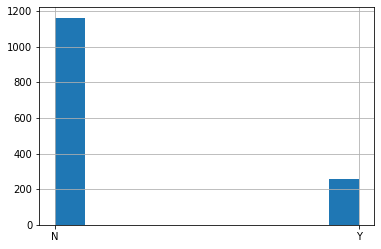

In [152]:
master_db_df['condition_financial'].hist()

In [ ]:
import re
import random
import secrets
from copy import deepcopy


def play(answer, all_words):
    possible_words = all_words
    word_length = len(answer)

    guesses = []
    clues = []

    for j in range(6):
        answer_copy = deepcopy(answer)
        guess = secrets.choice(possible_words)

        clue = []

        for j in range(5):
            if guess[j] == answer_copy[j]:
                clue.append("C")
            else:
                if guess[j] in answer_copy:
                    clue.append("B")
                    answer = answer_copy.replace(
                        guess[j], "0", 1
                    )  # Remove the character from the answer
                else:
                    clue.append("A")
            print(clue, guess, answer_copy, answer)

        guesses.append(guess)
        clues.append("".join(clue))

        if clues[-1] == "CCCCC":
            break

        possible_words = get_possible_words(clues, guesses, answer, possible_words)

        print(len(possible_words))
        if len(possible_words) == 0:
            possible_words = all_words

    return {"guesses": guesses, "clues": clues}

In [2]:
import tiktoken

# read the file
with open('sample_paper/A_19_2022_DoHonestyNudges.mmd', 'r') as f:
    text = f.read()

# encode the text
encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")
encoded_text = encoding.encode(text)

# get the length of the encoded text
length = len(encoded_text)

print("Length of encoded text:", length)



Length of encoded text: 15988


In [18]:
behavior_description_2 = """
Name the behavioral outcome in a few words. If the authors have a clear, short description of each \
behavior in the paper itself, copy their words here instead of paraphrasing. If their description \
is not clear enough on its own, or is very verbose, please paraphrase here. \
Give a JSON list of each behavioral outcome.
"""

A_19 = ArticleQA(read_files_to_vector(['sample_paper/A_19_2022_DoHonestyNudges.mmd']))
answer = A_19.query_context(behavior_description_2, 'JSON format')

In [12]:
answer


{'gpt_answer': {'query': '\nGive each experiment condition a one or two word name to describe it.  Where possible, use the label the research authors give it. Look at tables/figures to see their naming conventions for the conditions and use those if they exist. Give a JSON list with each experiment condition in it.\n',
  'result': '["Business as Usual", "Good Practice", "Novel Model"]',
  'source_documents': [Document(page_content='1. The sample doesn\'t capture the digitally excluded, or people not inclined to complete online surveys.\n2. Just because people are they would do something in an online experiment when playing with "house money" doesn\'t mean they will in real life. We therefore interpret play percentages as an upper bound of real behaviour, and focus primarily on differences between arms.\n3. Our sample size was chosen to provide adequate statistical power for our main outcomes of interest, and so we recommend interpreting comparisons for subgroups with caution.  \nAppend

In [ ]:
# Human answer

[
    "Claimed amount",
    "Claim Settlement Diff",
    "Session Cancellation or not",
    "Claim rejection or not",
    "Event description length",
]

# GPT 3.5 16k answer
[
    "Reduced claimed amount",
    "Reduced claim-settlement difference",
    "Increased session cancelation",
    "Reduced claim rejection",
    "Increased event description length",
]
# GPT 4 answer
[
    {
        "Behavioral Outcome": "Claimed Amount",
        "Description": "The amount claimed for settlement by the customer.",
    },
    {
        "Behavioral Outcome": "Claim-Settlement Difference",
        "Description": "The difference between the claimed amount and the final settlement amount issued by the provider.",
    },
    {
        "Behavioral Outcome": "Session Cancelation",
        "Description": "If the customer cancels filling the claim.",
    },
    {
        "Behavioral Outcome": "Claim Rejection",
        "Description": "If the customer’s claims are rejected.",
    },
    {
        "Behavioral Outcome": "Event Description Length",
        "Description": "The number of characters used to describe damages.",
    },
]



In [9]:
behavior_description_2 = """
Name the behavioral outcome in a few words. If the authors have a clear, short description of each \
behavior in the paper itself, copy their words here instead of paraphrasing. If their description \
is not clear enough on its own, or is very verbose, please paraphrase here. \
Give a JSON list of each behavioral outcome.
"""

expirment_condition = """
Give each experiment condition a one or two word name to describe it.  Where possible, use the label the research authors give it. Look at tables/figures to see their naming conventions for the conditions and use those if they exist. Give a JSON list with each experiment condition in it.
"""

P_157 = ArticleQA(read_files_to_vector(["sample_paper/P_157_2023_HowDoSlot_BIT.mmd"]))
answer = P_157.query_context(expirment_condition, "JSON format")

In [10]:
answer['gpt_answer']['result']

'["Business as Usual", "Good Practice", "Novel Model"]'

In [ ]:
# GPT 3.5 16k behavioral answer
[
    "Most of the slot game advert features tested did not affect behavior on average, nor the perceived chances of winning.",
    "Listing T&Cs that do not apply more saliently than those that do apply marginally reduced comprehension of the other T&Cs.",
    "Features that emphasized the game had low risk to potential reward or the 'ease of winning' increased total amount staked.",
    "Features that emphasized the game 'fun' reduced stakes.",
    "Features had a differential impact on individuals with high Problem Gambling Severity Index (short-form PGSI) scores and older individuals.",
]
# GPT 3.5 16k condition experiment answer
[
    "Business as usual",
    "Low risk to potential reward",
    "Ease of winning",
    "Fun-framing",
    "Good practice",
]

# GPT 4 behavioral answer
[
    "Comprehension of gambling odds",
    "Lower-risk gambling guidelines",
    "DSS gambling legging testing and implementation",
    "Evaluation of the 'take time to think' safer gambling message",
]
# GPT 4 condition experiment answer
[
    "Business as Usual", 
    "Good Practice", 
    "Novel Model"
]

In [5]:

expirment_condition = """
what are rawls two principles of justice?
"""

Rawls = ArticleQA(read_files_to_vector(["Rawls_Justice_as_Fairness.mmd"]))
answer = Rawls.query_context(expirment_condition, "free text")

In [6]:
answer['gpt_answer']['result']

'{\n"Principle1": "Each person must have equal right to the most extensive basic liberty compatible with similar liberty for others.",\n"Principle2": "Social and economic inequalities should be arranged so that they are both (a) reasonably expected to be to everyone\'s advantage, and (b) attached to positions and offices open to all."\n}'

In [7]:
Rawls.query_context('what are the defenition of persons', "free text")['gpt_answer']['result']

'The term "person" can be construed in various ways depending on the circumstances. It can refer to human individuals, but also to entities such as nations, provinces, business firms, churches, and teams. The principles of justice apply to all these instances, with a certain logical priority given to human individuals. The term "person" is used in an ambiguous manner, sometimes referring to mutually self-interested entities like families or other associations.'